In [52]:
# Necessary Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [53]:
# Load the training data
data = pd.read_csv("titanic/train.csv")
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [54]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [55]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [56]:
# Feature engineering: create new columns
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
data["IsAlone"] = (data["FamilySize"] == 1).astype(int)
data["Title"] = data["Name"].str.extract(" ([A-Za-z]+)\\.")

In [57]:
# Target and features
y = data["Survived"]
X = data.drop(columns=["Survived", "PassengerId", "Name", "Ticket", "Cabin"])

In [58]:
# Identify categorical and numerical columns
low_cardinality_cols = [col for col in X.columns if X[col].nunique() < 10 and X[col].dtype == "object"]
numerical_cols = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]

my_cols = low_cardinality_cols + numerical_cols
X = X[my_cols].copy()

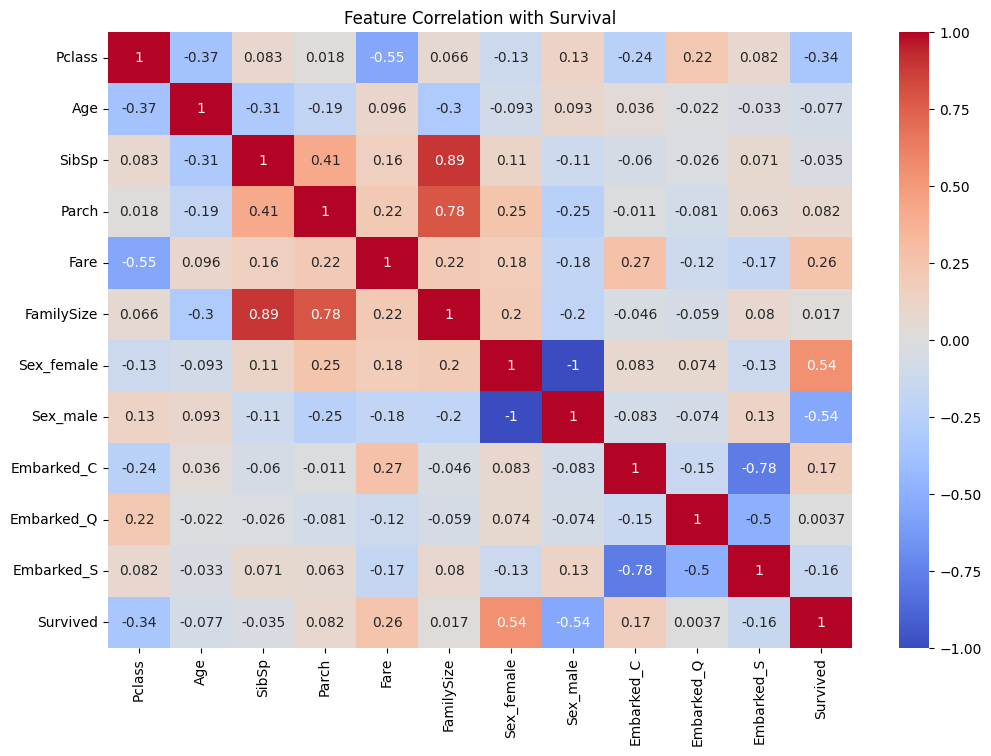

In [59]:
# Correlation Heatmap
encoded = pd.get_dummies(X)
encoded["Survived"] = y
plt.figure(figsize=(12, 8))
sns.heatmap(encoded.corr(), cmap="coolwarm", annot=True)
plt.title("Feature Correlation with Survival")
plt.show()

In [60]:
# Define transformers for preprocessing
numerical_transformer = SimpleImputer(strategy="mean")
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, low_cardinality_cols),
    ]
)

In [61]:
# Define the model and pipeline
my_model = XGBClassifier(n_estimators=100, random_state=42, learning_rate=0.08, n_jobs=5)

my_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", my_model)
])

# Cross-validation accuracy
cv_score = cross_val_score(my_pipeline, X, y, cv=20, scoring="accuracy").mean()
print(f"Cross-validated Accuracy: {cv_score:.4f}")

Cross-validated Accuracy: 0.8317


In [62]:
# Load test data and apply same feature engineering
test_data = pd.read_csv("titanic/test.csv")
test_data["FamilySize"] = test_data["SibSp"] + test_data["Parch"] + 1
test_data["IsAlone"] = (test_data["FamilySize"] == 1).astype(int)
test_data["Title"] = test_data["Name"].str.extract(" ([A-Za-z]+)\\.")
X_test = test_data[my_cols].copy()

In [63]:
# Train the model on full training data and predict on test set
my_pipeline.fit(X, y)
preds = my_pipeline.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": preds
})
submission.to_csv("submission.csv", index=False)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# Visualizations Section


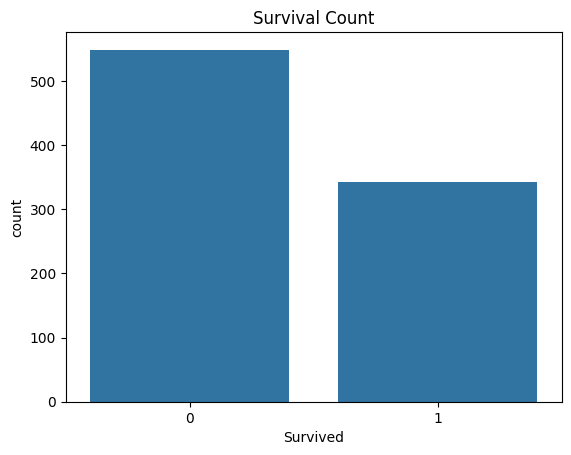

In [64]:
# Survival Count
sns.countplot(x="Survived", data=data)
plt.title("Survival Count")
plt.show()

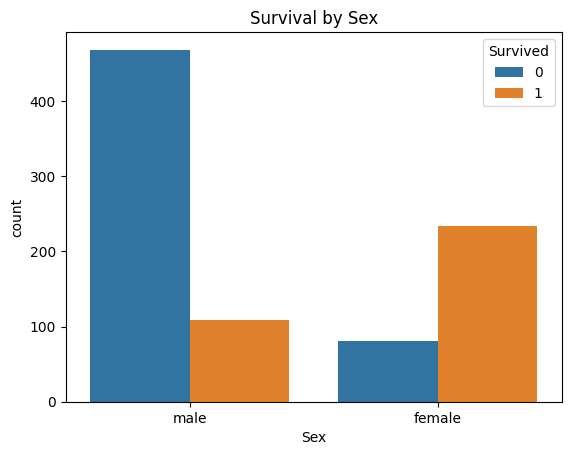

In [65]:
# Survival by Sex
sns.countplot(x="Sex", hue="Survived", data=data)
plt.title("Survival by Sex")
plt.show()

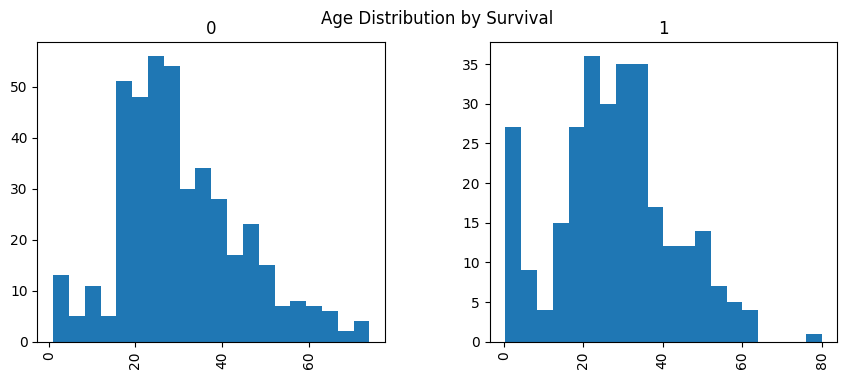

In [66]:
# Age Distribution by Survival
data["Age"].hist(by=data["Survived"], bins=20, figsize=(10, 4))
plt.suptitle("Age Distribution by Survival")
plt.show()